# Optimizing DataLoaders for Performance

Slow model training is a frequent obstacle in machine learning projects. While it's easy to assume that hardware is the limiting factor, performance issues often stem from a data bottleneck, where the powerful GPU is left waiting for data to process. This inefficiency can significantly prolong training cycles. Addressing how data is loaded and delivered to the accelerator is a vital step toward faster and more effective model development.


This lab serves as a hands on guide to overcoming these challenges by effectively utilizing the PyTorch DataLoader. You'll explore how its various parameters can be configured to build an efficient data pipeline that keeps your hardware fully engaged. By the end of this session, you'll have a practical understanding of how to diagnose and resolve common data loading issues.

In this notebook, you will:

* Investigate how enabling parallel data processing can dramatically reduce GPU idle time.

* Measure the impact of batching on processing speed and discover its relationship with hardware memory limits.

* Experiment with fine tuning parameters that can accelerate data transfer and manage data buffering for additional performance gains.

## 🚨 The Goal: Learning the Process, Not the Numbers 🚨

This notebook demonstrates how key `DataLoader` parameters affect performance. 
Because this lab operates in a **restrictive environment** with limited GPU and shared memory, a **controlled methodology is adopted** to isolate the impact of each setting. This involves aggressively clearing memory between runs to ensure every test is independent. *(Note: This cleanup is for demonstration purposes and is not a typical practice in projects where caching is beneficial).*


The results and optimal values shown are tailor-made to demonstrate the concepts **within this specific lab**. 
In real-world projects, the ideal configuration will always **differ depending on the unique hardware (CPU, GPU, RAM) and dataset (size, complexity)**.

Therefore, the key takeaway is the **process of experimentation** itself. This process provides a blueprint for how to test these parameters systematically and find the optimal configuration.

## Imports

In [1]:
import gc
import os
import json

import torch
from torch.utils.data import DataLoader

import helper_utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Measuring Performance

In the upcoming experiments, you will measure the **total time** it takes to load the entire dataset for one full epoch using the `measure_average_epoch_time` helper function.

This metric is the primary indicator of `DataLoader` performance in this lab. By minimizing the total epoch time, you can improve the overall efficiency of the training process.

## Tuning `num_workers` for Parallel Loading

When training deep learning models, you can face a **data loading bottleneck** when your powerful GPU sits idle waiting for the CPU to prepare data, which slows down the entire process. 
To solve this, PyTorch's `DataLoader` has a `num_workers` parameter. By default it is `0`, meaning a single process loads data, but increasing this value enables multiple processes to prepare data in parallel. 
Think of this as having several cooks preparing meals at once instead of just one, ensuring a constant flow of food and significantly speeding up the pipeline.

Finding the optimal number of workers is an important optimization step. 
To determine how many parallel processes your CPU can run to support the GPU's operations, a good starting point is to check the number of available CPU cores. 

**Note:**  Ultimately, the ideal number balances the capabilities of your specific hardware (CPU, GPU, and disk speed) with your **dataset's complexity**, which you can find only through experimentation.

In the following examples, you will experiment with several different worker settings to measure their impact on performance using the CIFAR10 dataset.

* Load the *CIFAR10* dataset.

In [3]:
trainset = helper_utils.download_and_load_cifar10()

* Before you begin experimenting, you can find out exactly how many cores your environment has by running the following code.

In [4]:
cpu_cores = os.cpu_count()
print(f"Number of available CPU cores: {cpu_cores}")

Number of available CPU cores: 4


<br>

**The Point of Diminishing Returns**

Just because you can set a high number of workers, sometimes even more than your available CPU cores, doesn't mean you should. Adding more workers is subject to a law of **diminishing returns**, where you eventually reach a point that adding more provides little benefit or can even slow things down. This is often due to two main factors:

* **System Limits**: Each worker requires system resources, including **shared memory**, to operate. Creating too many workers can exhaust this memory, which may cause your program to fail.


* **Resource Competition**: After a certain point, adding more workers creates its own overhead. It can lead to competition for other resources, like your disk's reading speed or the main Python process itself, creating a new bottleneck.

*Your goal is to find the "sweet spot", the **smallest number** of workers that keeps your GPU constantly supplied with data.*


To begin your experiment, you'll define a list to test six different `num_workers` values: `0`, `2`, `4`, `6`, `8`, and `10`.

In [5]:
# Define the list of num_workers values to test
workers_to_test = [0, 2, 4, 6, 8, 10]

* Execute the cell below to measure the time it takes to load the entire dataset, based on each `num_workers` value, while keeping a fixed `batch_size=32`.
* For each setting, the timing runs for five epochs. The first two are for **warm-up**, which allows system processes to stabilize, while the **final three** are averaged to calculate the stable loading time.

<div style="background-color: #FFD2D2; border: 1px solid #D8000C; color: black; padding: 15px; border-radius: 5px;">
    <p>🚨 <b>IMPORTANT NOTE:</b> Pay attention to any <code>RuntimeError</code> messages. These can occur with higher number of workers count on systems with limited <b>shared memory</b>. If you have modified the code and encounter this error, your <strong>first</strong> step should be to undo your modifications, then restart the kernel and run the original code to continue.</p>
</div>

In [6]:
def experiment_workers(workers_to_test, trainset, device):
    """
    Measures the data loading time for different numbers of workers.

    Args:
        workers_to_test: A list of integers representing the number of workers to test.
        trainset: The dataset to be loaded.
        device: The device to which the data will be moved (e.g., 'cpu' or 'cuda').
    """
    # Initialize a dictionary to store the results
    worker_times = {}

    # Loop through each worker number you want to test
    for nw in workers_to_test:
        print(f"--- Testing Number of Workers = {nw} ---")
        
        # Create a new DataLoader instance for each specific test.
        loader = DataLoader(trainset, 
                            batch_size=32, 
                            shuffle=True,
                            # The 'num_workers' is set to the current value in the loop.
                            num_workers=nw
                        )
        
        # Handle potential runtime errors
        try:
            # Time the data loading for one epoch and save it to the dictionary
            worker_times[nw] = helper_utils.measure_average_epoch_time(loader, device)
        except RuntimeError as e:
            # If an error occurs (often from running out of shared memory)
            print(f"\n❌ ERROR with {nw} workers. Likely a shared memory issue.")
            worker_times[nw] = float('inf')
            
        # Clean up the loader and call the garbage collector to free up memory
        del loader
        gc.collect()

        # Clear the PyTorch CUDA cache to free up GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return worker_times

Most experiments in this lab are executed using the helper function `run_experiment`. The purpose of this function is to **prevent re-running already successful experiments** in case of a crash or interruption.

By default, the function first checks if a result file for a given experiment already exists. If it does not find one, which is the case on the very first run, it will execute the computation and save the result. If a result file *is* found on a subsequent run, it will load the data from that file instead of computing it again.

Each experiment’s results are stored in the `checkpoint_experiments` folder, with one file per experiment (named after the experiment) in JSON format.

**Note**: If you need to force a specific experiment to run again, you can pass the `rerun=True` flag when calling the `run_experiment` function. For example: `run_experiment(..., rerun=True)`.

In [7]:
# Run the experiment to measure the data loading time for different numbers of workers.
worker_times = helper_utils.run_experiment(
    # A unique name for this experiment, used as the filename for the cached results.
    experiment_name='worker_times', 
    # The actual function that contains the experiment's logic.
    experiment_fcn=experiment_workers, 
    # The parameters to iterate over; in this case, a list of worker counts.
    cases=workers_to_test, 
    # The dataset required by the experiment function.
    trainset=trainset, 
    # The computation device (e.g., 'cpu' or 'cuda') to be used.
    device=device,
    # If False, the function will load results from the cache if they exist.
    # If True, it will force the experiment to run again and overwrite any old results.
    rerun=False
)

Results for experiment 'worker_times' not found. Running experiment.
Executing experiment 'worker_times'...
--- Testing Number of Workers = 0 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 9.16 seconds (warm-up)
  Epoch 2/5 | Time: 8.75 seconds (warm-up)
  Epoch 3/5 | Time: 8.88 seconds 
  Epoch 4/5 | Time: 8.95 seconds 
  Epoch 5/5 | Time: 8.87 seconds 

Average execution time (avg of last 3): 8.90 seconds

--- Testing Number of Workers = 2 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 7.32 seconds (warm-up)
  Epoch 2/5 | Time: 7.48 seconds (warm-up)
  Epoch 3/5 | Time: 7.44 seconds 
  Epoch 4/5 | Time: 7.30 seconds 
  Epoch 5/5 | Time: 7.44 seconds 

Average execution time (avg of last 3): 7.39 seconds

--- Testing Number of Workers = 4 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 5.16 seconds (warm-up)
  Epoch 2/5 | Time: 4.98 seconds (warm-up)
  Epoch 3/5 | Time: 4.84 seconds 
  Epoch 4/5 | Time: 4.85 seconds 
  Epoch 5/5 | Time: 4.86 seconds 

Average execution time (avg of last 3): 4.85 seconds

--- Testing Number of Workers = 6 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 4.97 seconds (warm-up)
  Epoch 2/5 | Time: 4.94 seconds (warm-up)
  Epoch 3/5 | Time: 5.07 seconds 
  Epoch 4/5 | Time: 4.94 seconds 
  Epoch 5/5 | Time: 4.94 seconds 

Average execution time (avg of last 3): 4.98 seconds

--- Testing Number of Workers = 8 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 5.15 seconds (warm-up)
  Epoch 2/5 | Time: 4.99 seconds (warm-up)
  Epoch 3/5 | Time: 5.00 seconds 
  Epoch 4/5 | Time: 5.02 seconds 
  Epoch 5/5 | Time: 4.96 seconds 

Average execution time (avg of last 3): 4.99 seconds

--- Testing Number of Workers = 10 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 5.01 seconds (warm-up)
  Epoch 2/5 | Time: 5.00 seconds (warm-up)
  Epoch 3/5 | Time: 5.04 seconds 
  Epoch 4/5 | Time: 5.01 seconds 
  Epoch 5/5 | Time: 5.04 seconds 

Average execution time (avg of last 3): 5.03 seconds

Results for 'worker_times' saved to ./checkpoint_experiments/worker_times.json


<br>

* With the performance data collected, you can now plot the results to visualize the impact of `num_workers` on loading time.

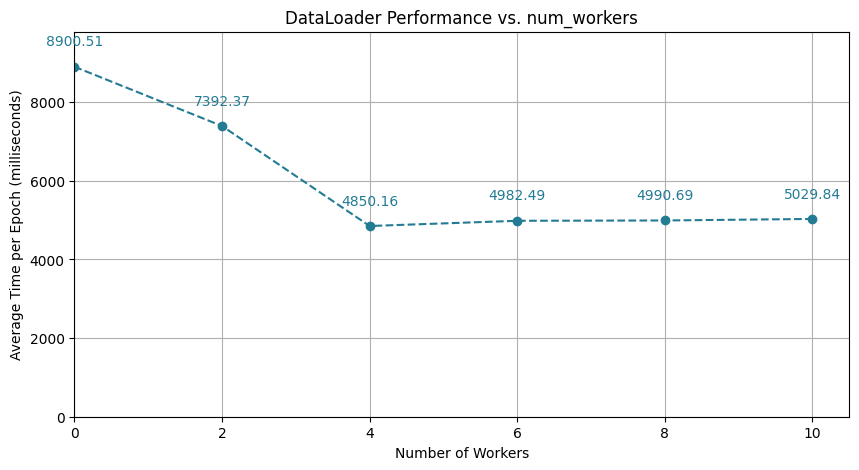

In [8]:
helper_utils.plot_performance_summary(
    worker_times, 
    title="DataLoader Performance vs. num_workers", 
    xlabel="Number of Workers", 
    ylabel="Average Time per Epoch (milliseconds)"
)

<br>

**Interpreting the Results**

The exact times you see can fluctuate slightly with each execution, depending on the current system load of the notebook environment. However, the general trend you observe should be clear:

* **The Initial Jump**: You will almost certainly see the most significant performance improvement in the first few workers. This demonstrates the powerful and immediate benefit of enabling parallel data loading.

* **Diminishing Returns**: Beyond 2 or 4 workers, the results often become less predictable. The time might plateau, fluctuate, or even increase slightly with more workers. This is a classic example of the law of diminishing returns, where adding more resources eventually stops providing a clear benefit and can create new overhead.

The goal is to find a reliable setting that is consistently fast. 
**For this environment**, it can be observed that `num_workers=6` is frequently a good and decent choice that balances speed with resource usage.

### Visualizing DataLoader Efficiency

The previous graph showed the total loading time per epoch. 
To better understand *why* some configurations are faster, you can visualize the **efficiency breakdown** of your DataLoader pipeline.

By using the `visualize_dataloader_efficiency` function, you can get this breakdown. 
Instead of measuring the entire epoch, it performs a **per-batch analysis** to reveal the pipeline's efficiency. 

You will obtain a normalized bar chart.
Each bar represents 100% of the total time spent per batch for different `num_workers` settings, composed of:

* The **blue** part of the bar represents **GPU Active Time** - the percentage of time spent on productive work (moving data to the GPU device).

* The **yellow** part represents **GPU Idle/Waiting Time** - the percentage of time the GPU spends waiting for the CPU to prepare and deliver the next batch. This idle time represents the pipeline bottleneck you want to minimize.


Think of the GPU as a customer at a restaurant and the CPU workers as chefs. 
The blue portion shows which proportion of the total time the customer spends eating (productive work), while the yellow portion shows how much time they spend waiting for the next dish to arrive (wasted time). 
*More efficient configurations will have larger blue sections and smaller yellow sections.*

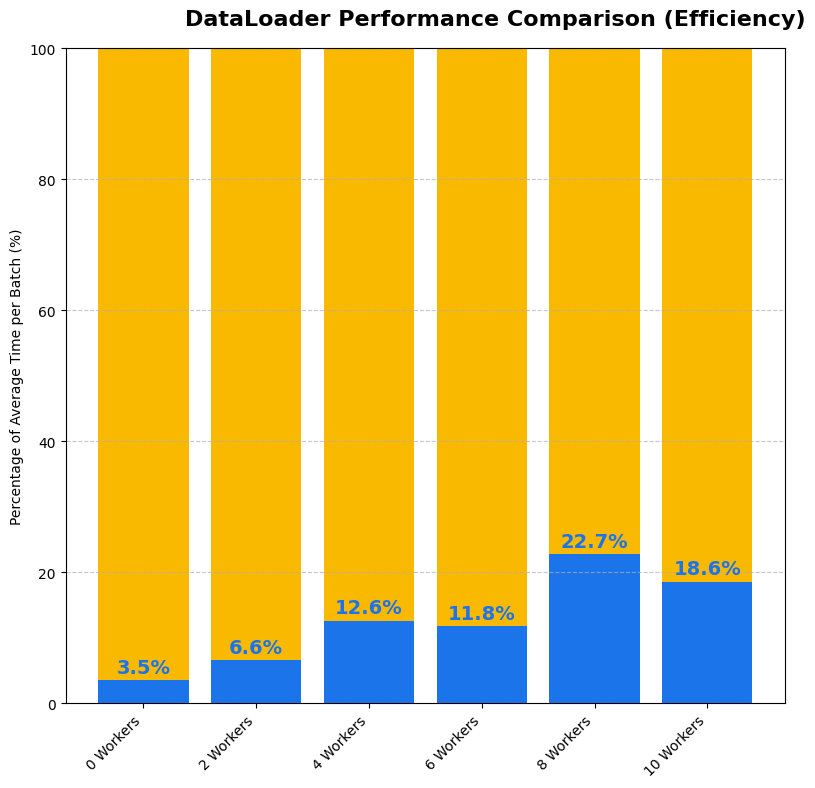

In [9]:
### This cell will take a few seconds to run

# Create the dictionary of loaders iteratively using a dictionary comprehension
# for each number in the 'workers_to_test' list.
loaders_to_compare = {
    f"{nw} Workers": DataLoader(trainset, batch_size=32, num_workers=nw) 
    for nw in workers_to_test
}

# Pass the generated dictionary to the plotting function.
helper_utils.visualize_dataloader_efficiency(loaders_to_compare, device)

# Clean up and release memory.
del loaders_to_compare
gc.collect()

# Clear the PyTorch CUDA cache to free up GPU memory.
if torch.cuda.is_available():
    torch.cuda.empty_cache()

<br>

**How to Interpret the Chart**

The bar chart helps you diagnose **why** some settings are faster by visualizing the **efficiency** of each `num_workers` configuration. 
It shows the proportion of time the GPU spends doing useful work versus waiting for data.

Because the performance *can fluctuate slightly with each execution* **in this shared environment**, your goal is to find a setting that is consistently both fast and efficient. 
For this experiment, you will see a significant efficiency improvement when moving from `0` to `2` workers, as the yellow "waiting" bar shrinks dramatically. After that, you will likely observe diminishing returns. 

As a general rule, you are looking for **GPU Efficiency**: high blue percentages and low yellow percentages.

## Exploring the Effect of `batch_size`

Along with the number of workers, the `batch_size` is another fundamental parameter for optimizing your data pipeline. Batching allows your model to process multiple data samples at the same time, which is essential for making efficient use of parallel hardware like a GPU. 
Think of it like a bus instead of a car; a bus (large batch size) transports many people at once, leading to a more efficient trip than sending each person in their own individual car (small batch size).

While a larger batch size can often lead to faster training by maximizing hardware utilization, it's not without its limits. 
The most significant constraint is **GPU memory**. 
As you increase the batch size, you'll see loading times improve and then plateau, until the batch becomes too large and causes an out of memory error. In the next experiment, you will hold the number of workers constant and test different batch sizes to observe their effect on performance.

* For this experiment, you'll define a list to test six different `batch_size` values: `16`, `32`, `64`, `128`, `256`, and `512`.

In [10]:
# Define the list of batch_size values to test
batch_sizes_to_test = [16, 32, 64, 128, 256, 512]

* Execute the cell below to measure the time it takes to load the entire dataset, based on each `batch_size` value, while keeping a fixed `num_workers=6`.
* For each setting, the timing runs for five epochs. The first two are for **warm-up**, which allows system processes to stabilize, while the **final three** are averaged to calculate the stable loading time.

<div style="background-color: #FFD2D2; border: 1px solid #D8000C; color: black; padding: 15px; border-radius: 5px;">
    <p>🚨 <b>IMPORTANT NOTE:</b> Pay attention to any <code>RuntimeError</code> messages. These often indicate that you have exceeded a system resource limit, such as running out of <b>shared memory</b> (common with a high number of workers) or <b>GPU memory</b> (common with a large batch size). If you have modified the code and encounter this error, your <strong>first</strong> step should be to undo your modifications, then restart the kernel and run the original code to continue.</p>
</div>

In [11]:
def experiment_batch_sizes(batch_sizes_to_test, trainset, device):
    """
    Measures the data loading time for different batch sizes.

    Args:
        batch_sizes_to_test: A list of integers representing the batch sizes to test.
        trainset: The dataset to be loaded.
        device: The device to which the data will be moved (e.g., 'cpu' or 'cuda').
    """
    # Initialize a dictionary to store the results
    batch_size_times = {}

    # Loop through each batch size you want to test
    for bs in batch_sizes_to_test:
        print(f"--- Testing Batch Size = {bs} ---")
        
        # Create a new DataLoader instance for each specific test.
        loader = DataLoader(trainset, 
                            # The 'batch_size' is set to the current value in the loop.
                            batch_size=bs, 
                            shuffle=True,
                            num_workers=6
                        )
        
        # Handle potential runtime errors, especially out-of-memory
        try:
            # Time the data loading for one epoch and save it to the dictionary
            batch_size_times[bs] = helper_utils.measure_average_epoch_time(loader, device)
        except RuntimeError as e:
            # If an error occurs (often from running out of GPU memory),
            print(f"\n❌ ERROR with batch size {bs}. Likely a GPU memory issue.")
            batch_size_times[bs] = float('inf')
            
        # Clean up the loader and call the garbage collector to free up memory
        # ensuring each test runs in a clean environment.
        del loader
        gc.collect()

        # Clear the PyTorch CUDA cache to free up GPU memory.
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
    return batch_size_times

In [12]:
# Run the experiment to measure the data loading time for different batch sizes.
batch_size_times = helper_utils.run_experiment(
    # A unique name for this experiment, used as the filename for the cached results.
    experiment_name="batch_size_times", 
    # The actual function that contains the experiment's logic.
    experiment_fcn=experiment_batch_sizes,
    # The parameters to iterate over; in this case, a list of different batch sizes.
    cases=batch_sizes_to_test,
    # The dataset required by the experiment function.
    trainset=trainset,
    # The computation device (e.g., 'cpu' or 'cuda') to be used.
    device=device,
    # If False, the function will load results from the cache if they exist.
    # If True, it will force the experiment to run again and overwrite any old results.
    rerun=False
)

Results for experiment 'batch_size_times' not found. Running experiment.
Executing experiment 'batch_size_times'...
--- Testing Batch Size = 16 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 6.22 seconds (warm-up)
  Epoch 2/5 | Time: 6.20 seconds (warm-up)
  Epoch 3/5 | Time: 6.35 seconds 
  Epoch 4/5 | Time: 6.83 seconds 
  Epoch 5/5 | Time: 6.82 seconds 

Average execution time (avg of last 3): 6.67 seconds

--- Testing Batch Size = 32 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 5.44 seconds (warm-up)
  Epoch 2/5 | Time: 5.34 seconds (warm-up)
  Epoch 3/5 | Time: 5.27 seconds 
  Epoch 4/5 | Time: 5.69 seconds 
  Epoch 5/5 | Time: 5.76 seconds 

Average execution time (avg of last 3): 5.57 seconds

--- Testing Batch Size = 64 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 5.08 seconds (warm-up)
  Epoch 2/5 | Time: 5.04 seconds (warm-up)
  Epoch 3/5 | Time: 4.85 seconds 
  Epoch 4/5 | Time: 4.82 seconds 
  Epoch 5/5 | Time: 4.98 seconds 

Average execution time (avg of last 3): 4.88 seconds

--- Testing Batch Size = 128 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 4.69 seconds (warm-up)
  Epoch 2/5 | Time: 4.68 seconds (warm-up)
  Epoch 3/5 | Time: 4.70 seconds 
  Epoch 4/5 | Time: 4.59 seconds 
  Epoch 5/5 | Time: 4.64 seconds 

Average execution time (avg of last 3): 4.65 seconds

--- Testing Batch Size = 256 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 4.57 seconds (warm-up)
  Epoch 2/5 | Time: 4.52 seconds (warm-up)
  Epoch 3/5 | Time: 4.52 seconds 
  Epoch 4/5 | Time: 4.37 seconds 
  Epoch 5/5 | Time: 4.29 seconds 

Average execution time (avg of last 3): 4.39 seconds

--- Testing Batch Size = 512 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 4.22 seconds (warm-up)
  Epoch 2/5 | Time: 4.28 seconds (warm-up)
  Epoch 3/5 | Time: 4.21 seconds 
  Epoch 4/5 | Time: 4.25 seconds 
  Epoch 5/5 | Time: 4.39 seconds 

Average execution time (avg of last 3): 4.29 seconds

Results for 'batch_size_times' saved to ./checkpoint_experiments/batch_size_times.json


<br>

* With the performance data collected, you can now plot the results to visualize the impact of `batch_size` on loading time.

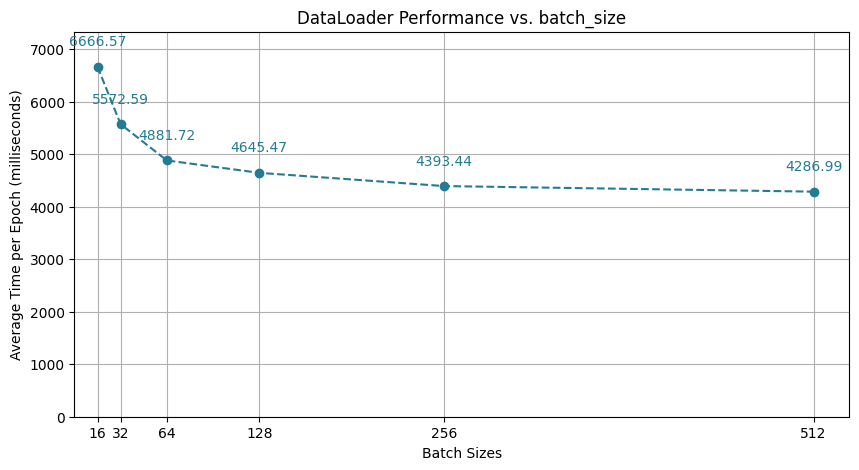

In [13]:
helper_utils.plot_performance_summary(
    batch_size_times, 
    title="DataLoader Performance vs. batch_size", 
    xlabel="Batch Sizes", 
    ylabel="Average Time per Epoch (milliseconds)"
)

<br>

**Interpreting the Results**

Again, the exact times can fluctuate with each run, but the overall trend should be very clear:

* **Initial Speedup**: You will notice a significant drop in loading time as you increase the `batch_size` from smaller values (e.g., 16 to 128). This is because larger batches make much more efficient use of the GPU's parallel processing capabilities, reducing the overhead per sample.

* **Diminishing Returns**: You can also see the law of diminishing returns in action. The performance gain from doubling the batch size from 256 to 512 is much smaller than the gain from doubling it from 16 to 32. This happens because the GPU is already becoming saturated with work.

The goal is to find the largest batch size that gives good performance without exceeding your system's limits. While larger is often faster, there is a hard limit. In this notebook environment, for example, increasing the `batch_size` to 1024 will cause a GPU out of memory error.

## Optimizing with `pin_memory`

Now that you have optimized `num_workers` and `batch_size`, you can explore another optimization to speed up the data transfer from the CPU to the GPU. While it can provide a significant speed boost, this feature comes with a trade-off: **it consumes more of your system's RAM**.

By default, data loaded by the CPU is in "pageable" memory, which requires an extra copy step before the GPU can access it. By setting `pin_memory=True` in the `DataLoader`, you instruct it to use a special "pinned" memory region. 
This allows for faster and more direct memory transfer to the GPU. 

This is similar to airport security; standard memory requires you to stop and unpack your bags into separate bins, while pinned memory is like having your bags prepped for the express lane, allowing for a much faster trip through the scanner.

In this experiment, you will take your best performing configuration from the previous steps and see how much additional speed you can gain by enabling `pin_memory`.

* Define a list with boolean values for `pin_memory`.

In [14]:
pin_memory_settings = [False, True]

* Execute the cell below to measure the time it takes to load the entire dataset for each `pin_memory` setting (`False` and `True`), while keeping a fixed `num_workers=6` and `batch_size=256`.

* For each setting, the timing runs for five epochs. The first two are for warm-up, which allows system processes to stabilize, while the final three are averaged to calculate the stable loading time.

In [15]:
def experiment_pin_memory(pin_memory_settings, trainset, device):
    """
    Measures the data loading time with and without pinned memory.

    Args:
        pin_memory_settings: A list of boolean values to test for pin_memory.
        trainset: The dataset to be loaded.
        device: The device to which the data will be moved (e.g., 'cpu' or 'cuda').
    """
    # Initialize a dictionary to store the results
    pin_memory_times = {}

    # Loop through each pin_memory setting
    for setting in pin_memory_settings:
        print(f"--- Testing with pin_memory = {setting} ---")
        
        # Create a DataLoader with the current pin_memory setting
        loader = DataLoader(trainset,
                            batch_size=256,
                            num_workers=6,
                            shuffle=True,
                            # The 'pin_memory' is set to the current boolean value in the loop.
                            pin_memory=setting
                        )
        
        try:
            # Measure performance and store the result in the dictionary
            pin_memory_times[setting] = helper_utils.measure_average_epoch_time(loader, device)
        except RuntimeError as e:
            # Print an error message if an exception occurs
            print(f"\n❌ An error occurred with pin_memory = {setting}: {e}")
            pin_memory_times[setting] = float('inf')
            
        # --- Memory Cleanup for each iteration ---
        del loader
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return pin_memory_times

In [16]:
# Run the experiment to measure the data loading time for pin memory either set as False or True.
pin_memory_times = helper_utils.run_experiment(
    # A unique name for this experiment, used as the filename for the cached results.
    experiment_name="pin_memory_times",
    # The actual function that contains the experiment's logic.
    experiment_fcn=experiment_pin_memory,
    # The parameters to iterate over; in this case, a list of boolean values for pin memory.
    cases=pin_memory_settings,
    # The dataset required by the experiment function.
    trainset=trainset, 
    # The computation device (e.g., 'cpu' or 'cuda') to be used.
    device=device,
    # If False, the function will load results from the cache if they exist.
    # If True, it will force the experiment to run again and overwrite any old results.
    rerun=False
)

Results for experiment 'pin_memory_times' not found. Running experiment.
Executing experiment 'pin_memory_times'...
--- Testing with pin_memory = False ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 4.27 seconds (warm-up)
  Epoch 2/5 | Time: 4.27 seconds (warm-up)
  Epoch 3/5 | Time: 4.29 seconds 
  Epoch 4/5 | Time: 4.23 seconds 
  Epoch 5/5 | Time: 4.40 seconds 

Average execution time (avg of last 3): 4.31 seconds

--- Testing with pin_memory = True ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 4.37 seconds (warm-up)
  Epoch 2/5 | Time: 4.30 seconds (warm-up)
  Epoch 3/5 | Time: 4.29 seconds 
  Epoch 4/5 | Time: 4.30 seconds 
  Epoch 5/5 | Time: 4.29 seconds 

Average execution time (avg of last 3): 4.29 seconds

Results for 'pin_memory_times' saved to ./checkpoint_experiments/pin_memory_times.json


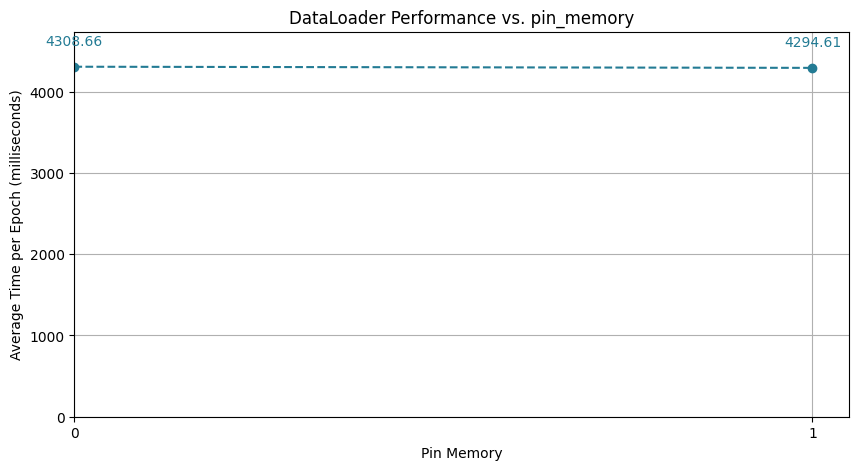

In [17]:
helper_utils.plot_performance_summary(
    pin_memory_times, 
    title="DataLoader Performance vs. pin_memory", 
    xlabel="Pin Memory", 
    ylabel="Average Time per Epoch (milliseconds)"
)

<br>

**Interpreting the Results**

While `pin_memory` is often recommended as a straightforward performance boost, the results in this specific environment show the opposite. 
This highlights that **optimizations are not always universal and must be tested**.

* **The Counter-Intuitive Result**: As seen in the chart, enabling `pin_memory=True` (represented by 1 on the x-axis) actually resulted in a slightly slower time per epoch compared to leaving it disabled (0).  
**Note**: In the rare case that your specific run shows a slight improvement with `pin_memory=True`, you will likely notice that the difference is marginal.


* **The Cost of Overhead**: This demonstrates an important concept in performance tuning: every optimization has a potential overhead.  
While pinning memory can speed up the final data transfer step to the GPU, the process of allocating that special memory itself has a small cost. In this highly optimized scenario, where "6 workers" and a "large batch size" are already keeping the GPU well-fed, the overhead cost of pinning memory outweighed its transfer speed benefit.


**The Takeaway on Experimentation**: This is a good example that achieving the best performance doesn't mean enabling every available feature. 
Optimization is an experimental process to *find the right combination of settings that work best for your specific hardware, software, and dataset*. 

## Fine-Tuning with `prefetch_factor`

You've now optimized the number of parallel workers and found the ideal batch size and `pin_memory` setting. The final knob you can turn for the `DataLoader` is the `prefetch_factor`. This parameter controls how many batches are pre-loaded into memory *per worker*.

By default, `prefetch_factor=2`. This means each worker will always try to have two batches ready and waiting in the background. For most use cases, this is enough to hide the data loading latency and keep the GPU fed.

The trade-off is straightforward: increasing the `prefetch_factor` can sometimes smooth out data loading stalls at the cost of using more **system RAM**, as more pre-fetched batches will be held in memory. Think of it as a larger buffer, it can help if data loading speeds are inconsistent, but it consumes more resources.

In this final experiment, you'll test different `prefetch_factor` values to see if moving away from the default provides any final performance gain for your already optimized pipeline.

* For this experiment, you'll define a list to test six different `prefetch_factor` values: `2`, `4`, `6`, `8`, `10`, and `12`.

In [18]:
# Define the list of prefetch_factor values to test
prefetch_factors_to_test = [2, 4, 6, 8, 10, 12]

* Execute the cell below to measure the time it takes to load the entire dataset for each `prefetch_factor` value, while using the optimal settings determined in previous experiments (`num_workers=6`, `batch_size=256`, and `pin_memory=False`).
* For each setting, the timing runs for five epochs. The first two are for warm-up, which allows system processes to stabilize, while the final three are averaged to calculate the stable loading time.

In [19]:
def experiment_prefetch_factor(prefetch_factors_to_test, trainset, device):
    """
    Measures the data loading time for different prefetch factor settings.

    Args:
        prefetch_factors_to_test: A list of integers representing the prefetch factors to test.
        trainset: The dataset to be loaded.
        device: The device to which the data will be moved (e.g., 'cpu' or 'cuda').
    """
    # Initialize a dictionary to store the results
    prefetch_factor_times = {}

    # Loop through each prefetch factor you want to test
    for pf in prefetch_factors_to_test:
        print(f"--- Testing prefetch_factor = {pf} ---")
        
        # Create a new DataLoader instance for each specific test, using the optimal settings
        loader = DataLoader(trainset, 
                            batch_size=256, 
                            shuffle=True,
                            num_workers=6,
                            pin_memory=False,
                            # The 'prefetch_factor' is set to the current value in the loop.
                            prefetch_factor=pf
                        )
        
        # Handle potential runtime errors
        try:
            # Time the data loading for one epoch and save it to the dictionary
            prefetch_factor_times[pf] = helper_utils.measure_average_epoch_time(loader, device)
        except RuntimeError as e:
            # If an error occurs, record it.
            print(f"\n❌ ERROR with prefetch_factor {pf}: {e}")
            prefetch_factor_times[pf] = float('inf')
            
        # Clean up the loader and call the garbage collector to free up memory
        # ensuring each test runs in a clean environment.
        del loader
        gc.collect()

        # Clear the PyTorch CUDA cache to free up GPU memory.
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return prefetch_factor_times

In [20]:
# Run the experiment to measure the data loading time for different prefetch factor.
prefetch_factor_times = helper_utils.run_experiment(
    # A unique name for this experiment, used as the filename for the cached results.
    experiment_name="prefetch_factor_times", 
    # The actual function that contains the experiment's logic.
    experiment_fcn=experiment_prefetch_factor,
    # The parameters to iterate over; in this case, a list of different prefetch factor.
    cases=prefetch_factors_to_test,
    # The dataset required by the experiment function.
    trainset=trainset, 
    # The computation device (e.g., 'cpu' or 'cuda') to be used.
    device=device,
    # If False, the function will load results from the cache if they exist.
    # If True, it will force the experiment to run again and overwrite any old results.
    rerun=False
)

Results for experiment 'prefetch_factor_times' not found. Running experiment.
Executing experiment 'prefetch_factor_times'...
--- Testing prefetch_factor = 2 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 4.23 seconds (warm-up)
  Epoch 2/5 | Time: 4.23 seconds (warm-up)
  Epoch 3/5 | Time: 4.30 seconds 
  Epoch 4/5 | Time: 4.31 seconds 
  Epoch 5/5 | Time: 4.32 seconds 

Average execution time (avg of last 3): 4.31 seconds

--- Testing prefetch_factor = 4 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 4.32 seconds (warm-up)
  Epoch 2/5 | Time: 4.33 seconds (warm-up)
  Epoch 3/5 | Time: 4.26 seconds 
  Epoch 4/5 | Time: 4.33 seconds 
  Epoch 5/5 | Time: 4.34 seconds 

Average execution time (avg of last 3): 4.31 seconds

--- Testing prefetch_factor = 6 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 4.30 seconds (warm-up)
  Epoch 2/5 | Time: 4.32 seconds (warm-up)
  Epoch 3/5 | Time: 4.37 seconds 
  Epoch 4/5 | Time: 4.40 seconds 
  Epoch 5/5 | Time: 4.37 seconds 

Average execution time (avg of last 3): 4.38 seconds

--- Testing prefetch_factor = 8 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 4.34 seconds (warm-up)
  Epoch 2/5 | Time: 4.35 seconds (warm-up)
  Epoch 3/5 | Time: 4.27 seconds 
  Epoch 4/5 | Time: 4.32 seconds 
  Epoch 5/5 | Time: 4.28 seconds 

Average execution time (avg of last 3): 4.29 seconds

--- Testing prefetch_factor = 10 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 4.35 seconds (warm-up)
  Epoch 2/5 | Time: 4.41 seconds (warm-up)
  Epoch 3/5 | Time: 4.33 seconds 
  Epoch 4/5 | Time: 4.26 seconds 
  Epoch 5/5 | Time: 4.25 seconds 

Average execution time (avg of last 3): 4.28 seconds

--- Testing prefetch_factor = 12 ---


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


  Epoch 1/5 | Time: 4.23 seconds (warm-up)
  Epoch 2/5 | Time: 4.29 seconds (warm-up)
  Epoch 3/5 | Time: 4.35 seconds 
  Epoch 4/5 | Time: 4.35 seconds 
  Epoch 5/5 | Time: 4.42 seconds 

Average execution time (avg of last 3): 4.37 seconds

Results for 'prefetch_factor_times' saved to ./checkpoint_experiments/prefetch_factor_times.json


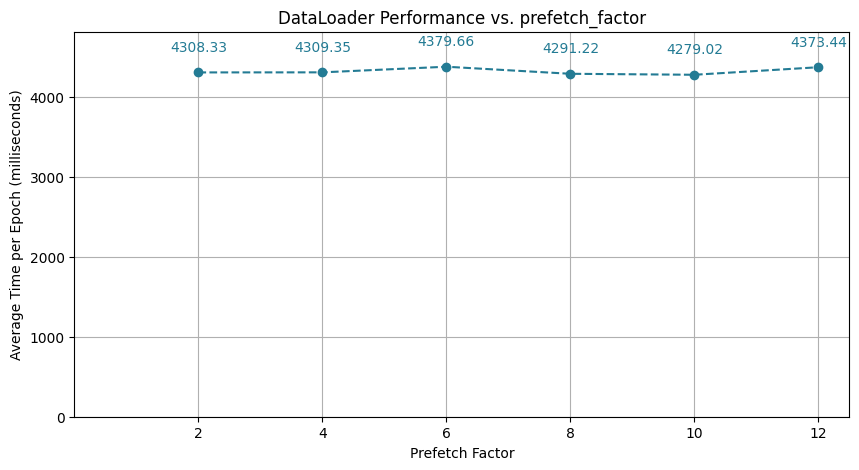

In [21]:
helper_utils.plot_performance_summary(
    prefetch_factor_times, 
    title="DataLoader Performance vs. prefetch_factor", 
    xlabel="Prefetch Factor", 
    ylabel="Average Time per Epoch (milliseconds)"
)

<br>

**Interpreting the Results**

This final experiment explores the `prefetch_factor` and perfectly illustrates the principle of diminishing returns in performance tuning.

* **The Point of Diminishing Returns**: After achieving significant speed-ups with `num_workers` and `batch_size`, you've reached the fine-tuning stage where improvements become marginal or non-existent. When you experiment with `prefetch_factor`, you should not expect to see a clear, repeatable winner. The performance will likely be "noisy," with minor fluctuations that don't point to a definitive improvement over the default.

* **The RAM vs. Stability Trade-Off**: Increasing the `prefetch_factor` creates a larger data buffer, which consumes more system RAM. While a larger buffer could theoretically guard against data loading stalls, an already efficient pipeline rarely benefits. You're essentially spending more memory for a larger safety net that your fast-moving workers likely don't need.

**Know When to Stop**: The most important lesson here is learning to recognize when a system is sufficiently optimized.  
Instead of chasing tiny, unstable gains with advanced parameters, it's often more practical and reliable to stick with a well-chosen default like `prefetch_factor=2`. It provides an excellent balance of performance and resource usage without adding unnecessary complexity.

## Try Yourself!

You explored four key `DataLoader` parameters for performance optimization: `num_workers`, `batch_size`, `pin_memory`, and `prefetch_factor`.

An important observation was that the final two parameters, `pin_memory` and `prefetch_factor`, had a negligible impact on performance. 
This outcome occurred because the data pipeline, with the CIFAR10 dataset, was already highly optimized for this specific lab environment by the primary settings of `num_workers=6` and `batch_size=256`.

An interesting challenge for you now is to experiment and see if `pin_memory` and `prefetch_factor` can be made to have a more significant impact. 
For instance, consider creating a scenario where the pipeline is intentionally sub-optimal. 
What happens to the `pin_memory` benchmark if `num_workers` is set to 0 or 2? Does `prefetch_factor` become more relevant then?

This is an opportunity to play around with different combinations to build a deeper intuition for how these parameters interact.

<div style="background-color: #FFD2D2; border: 1px solid #D8000C; color: black; padding: 15px; border-radius: 5px;">
<p>🚨 <b>A Friendly Reminder:</b> Remember to work within the constraints of this lab environment to avoid memory errors. If an error does occur, the simplest solution is to restart the kernel from the menu above, try a different combination of settings, and then run the cells below again.</p>
</div>

In [22]:
import gc
import os
import torch
from torch.utils.data import DataLoader
import helper_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
trainset = helper_utils.download_and_load_cifar10()

In the code cell, implement the logic where the `### Add your code here` placeholder is shown.

* `parameter_name`: For this variable, assign a string that describes the `DataLoader` parameter being tested (e.g., `'pin_memory'` or `'batch_size'`).

* `list_of_values_to_test`: For this variable, create a Python list containing the different values to experiment with (e.g., `[True, False]` or `[16, 32, 64]`).

* `loader`: For this variable, instantiate a `DataLoader`. Configure it with the desired settings and ensure the parameter being tested is set using the `current_value` variable from the loop.

**Important Note: 🚨** When creating the `DataLoader`, the variable must be named exactly `loader`. This is necessary because the memory cleanup code that follows depends on this specific variable name. **Do not modify the cleanup code**, as it is essential for ensuring each experiment runs independently.

In [24]:
def custom_experiment(trainset, device):
    """
    Runs a custom experiment to measure DataLoader performance.

    Args:
        trainset: The dataset to be used for the experiment.
        device: The device (e.g., 'cpu' or 'cuda') on which to run the test.

    Returns:
        A tuple containing:
            - A dictionary with the performance results.
            - The name of the parameter that was tested.
    """
    
    # Specify the name of the DataLoader parameter to be tested.
    # For example: parameter_name = 'prefetch_factor'
    
    parameter_name = ### Add your code here

    # Provide a list of values to iterate through for the specified parameter.
    # For example: list_of_values_to_test = [6, 8]
    
    list_of_values_to_test = ### Add your code 

    # Initialize an empty dictionary to store the performance results.
    results_dictionary = {}

    # Iterate over each value in the test list.
    for current_value in list_of_values_to_test:
        print(f"--- Testing {parameter_name} = {current_value} ---")
        
        # Configure and instantiate the DataLoader for the current test iteration.
        # For example: loader = DataLoader(trainset, 
                                       #  batch_size=64, 
                                       #  shuffle=True, 
                                       #  num_workers=2, 
                                       #  pin_memory=False,
                                       #  prefetch_factor=current_value
                                       # )
        
        loader = ## Add your code here
        
        # Measure the performance and handle potential runtime errors.
        try:
            # Calculate the average epoch time and store it in the results dictionary.
            results_dictionary[current_value] = helper_utils.measure_average_epoch_time(loader, device)
        except RuntimeError as e:
            # Handle cases where a runtime error occurs, such as an out-of-memory issue.
            print(f"\n❌ ERROR with {parameter_name} = {current_value}: {e}")
            results_dictionary[current_value] = float('inf')
            
        # Ensure each test run is independent by cleaning up memory.
        # Clean up the DataLoader instance to free up resources.
        del loader
        # Invoke the garbage collector to release unreferenced memory.
        gc.collect()

        # Clear the CUDA cache if a GPU is available.
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Return the dictionary of results and the name of the tested parameter.
    return results_dictionary, parameter_name

SyntaxError: invalid syntax (1094181968.py, line 18)

In [ ]:
results_dictionary, parameter_name = custom_experiment(trainset=trainset, device=device)

helper_utils.plot_performance_summary(
    results_dictionary, 
    title=f"DataLoader Performance vs. {parameter_name}", 
    xlabel=parameter_name.replace('_', ' ').title(), 
    ylabel="Average Time per Epoch (milliseconds)"
)

## Conclusion

This lab demonstrated the process of systematically optimizing PyTorch `DataLoader` parameters to improve data loading performance. 
Through a series of controlled experiments, you investigated the impact of `num_workers`, `batch_size`, `pin_memory`, and `prefetch_factor` on the total time required to load the CIFAR10 dataset for one epoch.

The most significant performance gain was achieved by increasing num_workers from 0 to 2, highlighting the immediate benefit of parallel data loading. Further increases in num_workers and batch_size showed a clear pattern of diminishing returns, where performance gains plateaued and eventually could even degrade due to resource competition and system overhead.

Ultimately, this investigation confirms that there is no single "best" configuration for a DataLoader. 
*The optimal settings are highly dependent on the specific interplay between the hardware, dataset complexity, and the parameters themselves*. 
The key takeaway is not the specific values found in this environment, but rather the experimental methodology itself. 
By systematically isolating and testing each parameter, one can effectively identify and eliminate data loading bottlenecks, thereby finding the most efficient configuration for any given training scenario.